In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from simulator import FraudForcastingDataSimulator
from models import WeibullCDFModel, LossDevelopmentCurveModel
import weibull as wb

In [2]:
MATURATION_TIME = 31*3

In [3]:
simulator = FraudForcastingDataSimulator(ultimate_loss_mean=100.0, ultimate_loss_std=10.0)
g = simulator.simulate_one_random_group()

Text(0, 0.5, 'Loss')

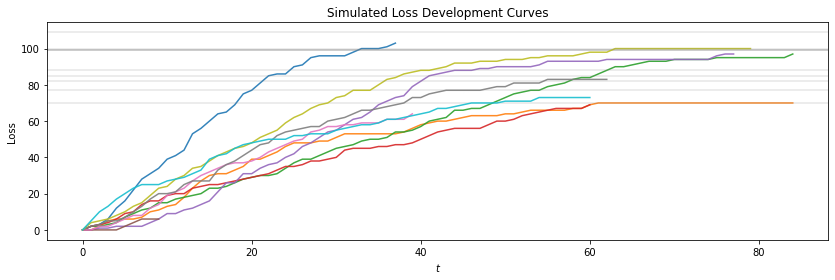

In [4]:
fig, ax = plt.subplots(figsize=(14, 4))

simulator = FraudForcastingDataSimulator(ultimate_loss_mean=100.0, ultimate_loss_std=15.0)

for _ in range(10):
    group = simulator.simulate_one_random_group()
    ax.plot(group['t'], group['y'], alpha=0.9)
    ax.axhline(group['ultimate_loss'][0], color='grey', alpha=0.2)

ax.set_title("Simulated Loss Development Curves")
ax.set_xlabel("$t$")
ax.set_ylabel("Loss")

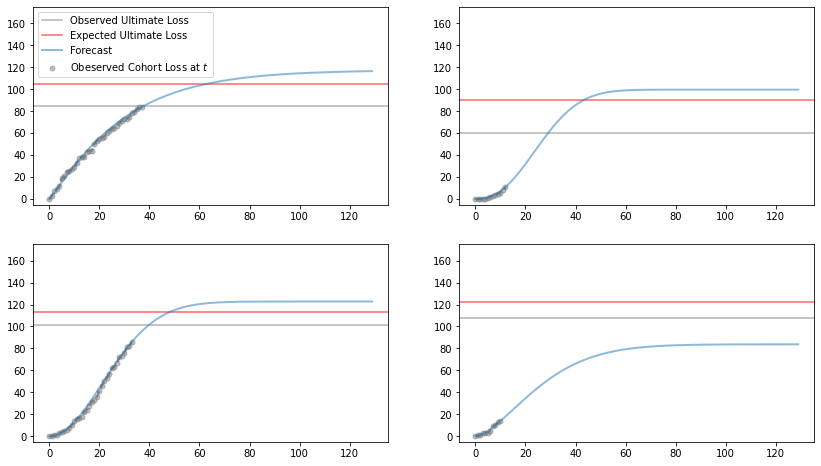

In [53]:
simulator = FraudForcastingDataSimulator(n_obs_min=5, n_obs_max=40, ultimate_loss_mean=100.0, ultimate_loss_std=15.0)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

for ax in axs.flatten():
    
    df = simulator.simulate_multiple_groups(n_groups=1)
    ax.plot(df['t'], df['y'], color='grey', linestyle='--', linewidth=2)
    ax.scatter(df['t'], df['y'], color='grey', s=25, alpha=0.5, label="Obeserved Cohort Loss at $t$")

    ax.axhline(df['ultimate_loss'][0], color='grey', alpha=0.6, label="Observed Ultimate Loss")
    ax.axhline(df['expected_ultimate_loss'][0], color='red', alpha=0.6, label="Expected Ultimate Loss")

    model = LossDevelopmentCurveModel(shrinkage=0.01)
    model.fit(df['t'].values, df['y'].values)
    forcasts = model.parameters[0] * wb.weibull(np.arange(130), *model.parameters[1:])
    ax.plot(np.arange(130), forcasts, alpha=0.5, linewidth=2, label="Forecast")
    
    ax.set_ylim([-5.0, 175.0])

axs[0][0].legend()

In [ ]:
model = WeibullCDFModel()
model.fit(group_id=df['id'], t=df['t'], y=df['y'])

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(14, 10), sharey=True)

ts = np.arange(MATURATION_TIME)

for ax, (idx, parameters) in zip(axs.flatten(), model.parameters_.items()):
    df[df['id'] == idx].plot('t', 'y', ax=ax, label=None, color='grey')
    ys = model._forecast_group(ts, group_id=idx)
    ax.plot(ts, ys, alpha=0.5)
    ax.set_xlim([0, MATURATION_TIME])

fig.tight_layout()

In [ ]:
simulator = FraudForcastingDataSimulator(ultimate_loss_mean=100.0, ultimate_loss_std=10.0)
df = simulator.simulate_multiple_groups(n_groups=20)

In [ ]:
class FraudForcasingModel:
    
    def __init__(self, initial_ultimate_estimate=200):
        self.initial_ultimate_estimate = initial_ultimate_estimate
        self.weibull_model_ = None
        self.ultimate_losses_ = None
    
    def fit(self, t: pd.Series, group_ids: pd.Series, y: pd.Series):
        y = y.copy()
        groups, n_groups = group_ids.unique(), len(group_ids.unique())
        ultimate_losses = pd.Series(
            np.full(n_groups, self.initial_ultimate_estimate),
            index=groups
        )
        maximum_losses = y.groupby(group_ids).max() + 0.01
        for _ in range(5):
            # These shenannigans are needed beacuse pd.Series does not 
            # have a set_index method :(
            y.index = group_ids
            working_y = y / ultimate_losses
            y = y.reset_index(drop=True)
            working_y = working_y.reset_index(drop=True)
            working_y.name = 'y'
            # Fit a model for the underlying proportion time series
            weibull_model = WeibullCDFModel()
            weibull_model.fit(group_id=group_ids, t=t, y=working_y)
            # Build the series of predicted values from the fit model.
            proportion_forecasts = weibull_model.forecast_groups(t, group_ids).iloc[:, 0]
            #forecasts = (ultimate_losses * proportion_forecasts).reset_index(drop=True)
            # Update the estimates for ultimate losses
            #return proportion_forecasts
#             ultimate_losses =  np.exp(
#                 (np.log(y[y > 0]) - np.log(proportion_forecasts[y > 0])).groupby(group_ids[y > 0]).mean()
#             )
            numerator = (y * proportion_forecasts).groupby(group_ids).sum()
            denominator = (proportion_forecasts**2).groupby(group_ids).sum()
            ultimate_losses = numerator / denominator
            ultimate_losses = pd.concat([ultimate_losses, maximum_losses], axis=1).max(axis=1)
            print(ultimate_losses)

In [ ]:
forecast = FraudForcasingModel()

In [ ]:
fsts = forecast.fit(group_ids=df['id'], t=df['t'], y=df['y'])

In [ ]:
df.groupby('id').max()

In [ ]:
fsts

In [ ]:
np.log(df['y'][df['y'] > 0]) - np.log(fsts[df['y'] > 0])

In [ ]:
fsts[df['y'] > 0]

In [ ]:
fsts.reset_index()[df['y'] > 0]